## Dataset and description: 
Details and data available for download: https://www.kaggle.com/c/kkbox-churn-prediction-challenge/notebooks?sortBy=hotness&group=everyone&pageSize=20&competitionId=7163&language=Python

In this challenge, you are asked to predict whether a user will churn after his/her subscription expires. Specifically, we want to forecast if a user make a new service subscription transaction within 30 days after the current membership expiration date.

The key fields to determine churn/renewal are transaction date, membership expiration date, and is_cancel. Note that the is_cancel field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.

#### Predictor:
`is_churn`: Churn is defined as whether the user did not continue the subscription within 30 days of expiration. `is_churn` = 1 means churn, `is_churn` = 0 means renewal.

#### Features:
- `payment_method_id`: payment method
- `payment_plan_days`: length of membership plan in days
- `plan_list_price`: in New Taiwan Dollar (NTD)
- `actual_amount_paid`: in New Taiwan Dollar (NTD)
- `is_auto_renew`
- `transaction_date`: format %Y%m%d
`membership_expire_date`: format %Y%m%d
- `is_cancel`: whether or not the user canceled the membership in this transaction.
- `user_log_date`: format %Y%m%d
- `num_25`: # of songs played less than 25% of the song length
- `num_50`: # of songs played between 25% to 50% of the song length
- `num_75`: # of songs played between 50% to 75% of of the song length
- `num_985`: # of songs played between 75% to 98.5% of the song length
- `num_100`: # of songs played over 98.5% of the song length
- `num_unq`: # of unique songs played
- `total_secs`: total seconds played
- `city`
- `bd`: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
- `gender`
- `registered_via`: registration method
- `registration_init_time`: format %Y%m%d
- `expiration_date`: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

#### ID Field:
`msno`: user id

#### Other notes:
The _v2_ data was used for this notebook because the original/v1 data was extremely large and yielded memory problems. There were memory reduction techniques on Kaggle, but for the scope and time of this project, that was not tackled.

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import pickle
import gc; gc.enable()
from time import time
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Pool, cpu_count

from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout, SimpleRNN, LSTM, Bidirectional, Flatten, Embedding, GRU
from keras import regularizers

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Using TensorFlow backend.


In [2]:
from subprocess import check_output
print(check_output(["ls", "data/kkbox-churn-prediction-challenge"]).decode("utf8"))

WSDMChurnLabeller.scala
members_v3 2.csv
members_v3.csv
sample_submission_v2.csv
sample_submission_zero.csv
train.csv
train_v2.csv
transactions.csv
transactions_v2.csv
user_logs.csv
user_logs_v2.csv



In [3]:
# Load in train and test
train = pd.read_csv('data/kkbox-churn-prediction-challenge/train.csv')
train = pd.concat((train, pd.read_csv('data/kkbox-churn-prediction-challenge/train_v2.csv')),axis=0, ignore_index=True).reset_index(drop=True)
#test = pd.read_csv('data/kkbox-churn-prediction-challenge/sample_submission_v2.csv')

# members
members = pd.read_csv('data/kkbox-churn-prediction-challenge/members_v3.csv')
train = train.merge(members, on = 'msno', how = 'left')
#test = test.merge(members, on = 'msno', how = 'left')

# transactions
transactions = pd.read_csv('data/kkbox-churn-prediction-challenge/transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv('data/kkbox-churn-prediction-challenge/transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','trans_count']
train = pd.merge(train, transactions, how='left', on='msno')
#test = pd.merge(test, transactions, how='left', on='msno')

transactions = pd.read_csv('data/kkbox-churn-prediction-challenge/transactions_v2.csv') 
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')

train = pd.merge(train, transactions, how='left', on='msno')
#test = pd.merge(test, transactions, how='left', on='msno')
transactions=[]
print(train.keys())

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'trans_count', 'payment_method_id',
       'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
       'is_auto_renew', 'transaction_date', 'membership_expire_date',
       'is_cancel'],
      dtype='object')


In [4]:
user_logs = pd.read_csv('data/kkbox-churn-prediction-challenge/user_logs_v2.csv', usecols=['msno'])
user_logs = pd.DataFrame(user_logs['msno'].value_counts().reset_index())
user_logs.columns = ['msno','logs_count']
train = pd.merge(train, user_logs, how='left', on='msno')
#test = pd.merge(test, user_logs, how='left', on='msno')
print(train.keys())

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'trans_count', 'payment_method_id',
       'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
       'is_auto_renew', 'transaction_date', 'membership_expire_date',
       'is_cancel', 'logs_count'],
      dtype='object')


In [5]:
def transform_df(df):
    df = pd.DataFrame(df)
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

def transform_df2(df):
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

In [6]:
print(train.keys())

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'trans_count', 'payment_method_id',
       'payment_plan_days', 'plan_list_price', 'actual_amount_paid',
       'is_auto_renew', 'transaction_date', 'membership_expire_date',
       'is_cancel', 'logs_count'],
      dtype='object')


In [7]:
last_user_logs = []
last_user_logs.append(transform_df(pd.read_csv('data/kkbox-churn-prediction-challenge/user_logs_v2.csv')))
last_user_logs = pd.concat(last_user_logs, axis=0, ignore_index=True).reset_index(drop=True)
last_user_logs = transform_df2(last_user_logs)
print ('merging user logs features...')
train = pd.merge(train, last_user_logs, how='left', on='msno')
#test = pd.merge(test, last_user_logs, how='left', on='msno')
last_user_logs=[]

gender = {'male':1, 'female':2}
train['gender'] = train['gender'].map(gender)
#test['gender'] = test['gender'].map(gender)

train = train.fillna(0)
#test = test.fillna(0)



merging user logs features...


In [8]:
print("Train shape: ", train.shape)
#print("Test shape: ", test.shape)
print(train.head())

print("Churn ratio", len(train[train['is_churn'] == 1])/len(train))

Train shape:  (1963891, 25)
                                           msno  is_churn  city    bd  gender  \
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1  18.0  36.0     2.0   
1  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1  10.0  38.0     1.0   
2  fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=         1  11.0  27.0     2.0   
3  mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=         1  13.0  23.0     2.0   
4  XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=         1   3.0  27.0     1.0   

   registered_via  registration_init_time  trans_count  payment_method_id  \
0             9.0              20050406.0            2                0.0   
1             9.0              20050407.0           23                0.0   
2             9.0              20051016.0           10                0.0   
3             9.0              20051102.0            3               40.0   
4             9.0              20051228.0            9               38.0   

   payment_plan_days  

In [9]:
# Create standardized features
cols = [c for c in train.columns if c not in ['is_churn','msno']]

features = train[cols]
features = pd.DataFrame(StandardScaler().fit_transform(features))
response = train['is_churn']
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.2, random_state=123)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train.head())

(1571112, 23)
(392779, 23)
(1571112,)
(392779,)
               0         1         2         3         4         5         6   \
1503487 -0.667427 -0.615528 -0.744385  0.312943  0.364768 -0.807681  0.432716   
1731761 -0.667427 -0.615528 -0.744385  1.015106  0.361744  0.472053  0.101595   
1457984 -0.667427 -0.615528 -0.744385  0.312943  0.363256  0.355714  0.432716   
1476024 -0.667427 -0.615528 -0.744385  0.312943  0.363302  0.006695  0.432716   
1831955  1.541441  1.596697  1.797263 -1.091383  0.358477 -1.622058 -0.891768   

               7         8         9   ...        13        14        15  \
1503487 -0.073893 -0.274676 -0.273453  ... -0.151438  0.644190  0.560553   
1731761 -0.073893  0.069322  0.070406  ... -0.151438  0.118130  0.560553   
1457984 -0.073893 -0.274676 -0.273453  ... -0.151438 -1.197020 -1.783953   
1476024 -0.073893 -0.274676 -0.273453  ... -0.151438 -0.232576  0.560553   
1831955 -0.073893  0.282601  0.283598  ... -0.151438  1.170250  0.560553   

        

In [11]:
# Format the data for RNN
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# reshape to [samples, time_steps, n_features]
time_steps = 5
X_train, y_train = create_dataset(X_train, y_train, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(max(y_train))
print(max(y_test))

(1571107, 5, 23) (1571107,)
(392774, 5, 23) (392774,)
1
1


In [12]:
# Make a simple model:
model =Sequential()
model.add(LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.add(Dense(units=1))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

print(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               77824     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 78,465
Trainable params: 78,209
Non-trainable params: 256
_________________________________________________________________
Train on 1413996 samples, validate on 157111 samples
Epoch 1/5
1413996/1413996 [==============================] - 

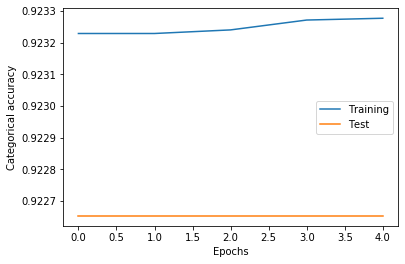

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])



In [14]:
# Way too many epochs, started at 30 and reduced to 5
# Changing to Bidirections Simple RNN
model =Sequential()
model.add(Bidirectional(SimpleRNN(32, return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(units=16))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.add(Flatten())
model.add(Dense(units=1))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

print(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 64)             3584      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5, 16)             1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 16)             64        
_________________________________________________________________
activation_2 (Activation)    (None, 5, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
def report_results(model, X, y):
    pred = model.predict_classes(X)    
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    cm = confusion_matrix(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec, 'confusion_matrix': cm}
    return result

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.0, 'acc': 0.9233783295228299, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[362679,      0],
       [ 30095,      0]])}


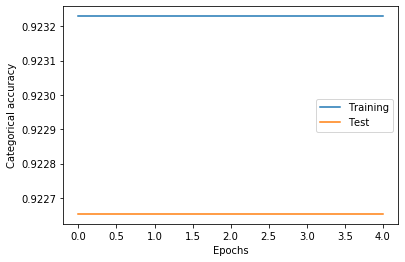

In [16]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)

# error in prediction, I think this is because I did not create the test time_steps. are we supposed to do that? Probably.
# Adding in above and rerunning time-step processing for test data as well


In [17]:
# Using the tips for vanishing/exploding gradients from this blog: https://www.dlology.com/blog/how-to-deal-with-vanishingexploding-gradients-in-keras/
# Using GRU instead of LSTM per the blog recommendations
# Computationally more expensive but better for POCs like this
model=Sequential()
# model.add(Embedding(input_dim=1000, output_dim=128))
model.add(GRU(64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

print(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                16896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Train on 1413996 samples, validate on 157111 samples
Epoch 1/5
1413996/1413996 [==============================] - 80s 56us/step - loss: 0.2742 - accuracy: 0.9226 - val_loss: 0.2724 - val_accuracy: 0.9227
Epoch 2/5
1413996/1413996 [==============================] - 60s 43us/step - loss: 0.2719 - accuracy: 0.9232 - val_loss: 0.2723 - val_accuracy: 0.9227
Epoch 3/5
1413996/1413996

{'f1': 0.0, 'acc': 0.9233783295228299, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[362679,      0],
       [ 30095,      0]])}


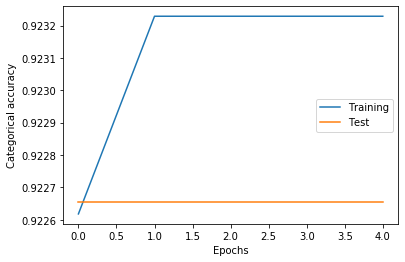

In [18]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)

# error in prediction, I think this is because I did not create the test time_steps. are we supposed to do that? Probably.
# Adding in above and rerunning time-step processing for test data as well


In [19]:
# Increasing the batch size after watching the accuracy decrease rapidly during an epoch
# Using the tips for vanishing/exploding gradients from this blog: https://www.dlology.com/blog/how-to-deal-with-vanishingexploding-gradients-in-keras/
# Using GRU instead of LSTM per the blog recommendations
# Computationally more expensive but better for POCs like this
model=Sequential()
# model.add(Embedding(input_dim=1000, output_dim=128))
model.add(GRU(64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=1026,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

print(history)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 64)                16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Train on 1413996 samples, validate on 157111 samples
Epoch 1/3
1413996/1413996 [==============================] - 75s 53us/step - loss: 0.2787 - accuracy: 0.9211 - val_loss: 0.2725 - val_accuracy: 0.9227
Epoch 2/3
1413996/1413996 [==============================] - 58s 41us/step - loss: 0.2721 - accuracy: 0.9232 - val_loss: 0.2724 - val_accuracy: 0.9227
Epoch 3/3
1413996/1413996

{'f1': 0.0, 'acc': 0.9233783295228299, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[362679,      0],
       [ 30095,      0]])}


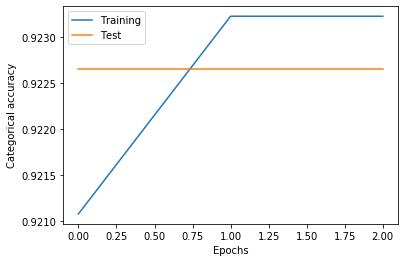

In [20]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)


In [21]:
# Model 2, adding SimpleRNN, GRU, or LSTM to the best model found here: https://www.kaggle.com/ripcurl/feedforward-neural-network-0-12174
lsize = 128
model = Sequential()
# model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dense(lsize, input_dim=int(X_train.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

# Fit the model
history = model.fit(X_train, y_train, epochs=5, batch_size=1026,
                    validation_split=0.2, verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               77824     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

/Users/annelise/.pyenv/versions/3.6.4/envs/csci/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.0, 'acc': 0.9233783295228299, 'precision': 0.0, 'recall': 0.0, 'confusion_matrix': array([[362679,      0],
       [ 30095,      0]])}


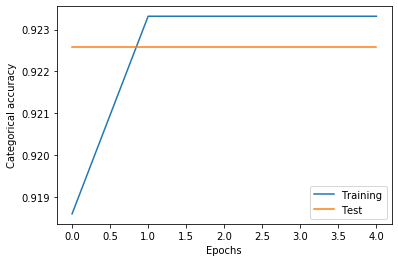

In [22]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)


In [24]:
# Try it without RNN
# Model 2, adding SimpleRNN, GRU, or LSTM to the best model found here: https://www.kaggle.com/ripcurl/feedforward-neural-network-0-12174

# Create standardized features
cols = [c for c in train.columns if c not in ['is_churn','msno']]

features = train[cols]
features = pd.DataFrame(StandardScaler().fit_transform(features))
response = train['is_churn']
X_train_notrnn, X_test_notrnn, y_train_notrnn, y_test_notrnn = train_test_split(features, response, test_size = 0.2, random_state=123)

lsize = 128
model = Sequential()
model.add(Dense(lsize, input_dim=int(X_train_notrnn.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

# Fit the model
history = model.fit(X_train_notrnn, y_train_notrnn, epochs=5, batch_size=1026,
                    validation_split=0.2, verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               3072      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)               

{'f1': 0.6099828939865783, 'acc': 0.9547226302831873, 'precision': 0.8970521834483648, 'recall': 0.4621033394251537, 'confusion_matrix': array([[361088,   1596],
       [ 16188,  13907]])}


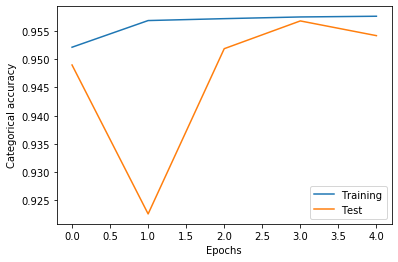

In [25]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test_notrnn, y_test_notrnn)
print(test_results)


In [ ]:
# Other things to try:
# Do some feature tuning and selection
# sample train/test on visitor, not just randomness. that will actually probably make the RNN function properly
# account for unbalanced data set

In [ ]:
# Unbalanced data set mitigation
from imblearn.over_sampling import  RandomOverSampler

# Reset data without time frame
cols = [c for c in train.columns if c not in ['is_churn','msno']]

features = train[cols]
features = pd.DataFrame(StandardScaler().fit_transform(features))
response = train['is_churn']
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.2, random_state=123)

# Over sample
sampler = RandomOverSampler()
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('RandomOverSampler {}'.format(Counter(y_rs)))

# Format the data for RNN
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# reshape to [samples, time_steps, n_features]
time_steps = 5
X_rs, y_rs = create_dataset(X_rs, y_rs, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

print(X_rs.shape, y_rs.shape)
print(X_test.shape, y_test.shape)


lsize = 128
model = Sequential()
model.add(LSTM(
  units=128,
  input_shape=(X_rs.shape[1], X_rs.shape[2])
))
model.add(Dense(lsize, input_dim=int(X_rs.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

# Fit the model
history = model.fit(X_rs, y_rs, epochs=5, batch_size=1026,
                    validation_split=0.2, verbose=1)

RandomOverSampler Counter({0: 1450406, 1: 1450406})
(2900807, 5, 23) (2900807,)
(392774, 5, 23) (392774,)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               77824     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)                256       
______________

In [ ]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# Reset data without time frame
cols = [c for c in train.columns if c not in ['is_churn','msno']]

features = train[cols]
features = pd.DataFrame(StandardScaler().fit_transform(features))
response = train['is_churn']
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.2, random_state=123)

# Over sample
sampler = RandomOverSampler()
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('RandomOverSampler {}'.format(Counter(y_rs)))

# Format the data for RNN
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# reshape to [samples, time_steps, n_features]
time_steps = 5
X_rs, y_rs = create_dataset(X_rs, y_rs, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

print(X_rs.shape, y_rs.shape)
print(X_test.shape, y_test.shape)

lsize = 128
model = Sequential()
# model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(
  units=128,
  input_shape=(X_rs.shape[1], X_rs.shape[2])
))
model.add(Dense(lsize, input_dim=int(X_rs.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

# Fit the model
history = model.fit(X_rs, y_rs, epochs=5, batch_size=1026,
                    validation_split=0.2, verbose=1)

In [ ]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# Reset data without time frame
cols = [c for c in train.columns if c not in ['is_churn','msno']]

features = train[cols]
features = pd.DataFrame(StandardScaler().fit_transform(features))
response = train['is_churn']
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.2, random_state=123)

# Over sample
sampler = RandomOverSampler()
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print('RandomOverSampler {}'.format(Counter(y_rs)))

# Format the data for RNN
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# reshape to [samples, time_steps, n_features]
time_steps = 5
X_rs, y_rs = create_dataset(X_rs, y_rs, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

print(X_rs.shape, y_rs.shape)
print(X_test.shape, y_test.shape)

lsize = 128
model = Sequential()
# model.add(SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(
  units=128,
  input_shape=(X_rs.shape[1], X_rs.shape[2])
))
model.add(Dense(lsize, input_dim=int(X_rs.shape[1]),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(int(lsize/4),kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

# Fit the model
history = model.fit(X_rs, y_rs, epochs=5, batch_size=1026,
                    validation_split=0.2, verbose=1)

In [ ]:
# Plot and predict before moving on
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Categorical accuracy')
plt.legend(['Training','Test'])

test_results = report_results(model, X_test, y_test)
print(test_results)
